In [1]:
import json
import pandas as pd
import numpy as np
import nibabel as nib
from pycirclize import Circos
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
data_dir = ""  ### set to directory for data used in/throughout analysis

In [3]:
#### load the precalculated shortest paths on the S1200 average surface
f = open(f"{data_dir}/Left.Schaefer400Paths.json")
left_paths = json.load(f)
f = open(f"{data_dir}/Right.Schaefer400Paths.json")
right_paths = json.load(f)
### load up the distances and FC dictonaries
### distances
with open("positive_distances.json") as json_file:
    positiveDistances = json.load(json_file)

with open("negativeDistances.json") as json_file:
    negativeDistances = json.load(json_file)
### FC edges
with open("positiveFC.json") as json_file:
    positiveFC = json.load(json_file)

with open("negativeFC.json") as json_file:
    negativeFC = json.load(json_file)

#### load  data
#### Load Distances
LSchaeferDist = pd.read_csv(f"{data_dir}/Schaefer400Geodesic.L.mat.csv")
LSchaeferDist.rename(columns={"Unnamed: 0": "Subject"}, inplace=True)
LSchaeferDist.set_index("Subject", inplace=True)
LSchaeferDist.columns = [f"L.{i}" for i in LSchaeferDist.columns]

RSchaeferDist = pd.read_csv(f"{data_dir}/Schaefer400Geodesic.R.mat.csv")
RSchaeferDist.rename(columns={"Unnamed: 0": "Subject"}, inplace=True)
RSchaeferDist.set_index("Subject", inplace=True)
RSchaeferDist.columns = [f"R.{i}" for i in RSchaeferDist.columns]


#### Load FC
LSchaeferFunc = pd.read_csv(f"{data_dir}/Schaefer200FConn.L.mat.csv")
LSchaeferFunc.rename(columns={"Unnamed: 0": "Subject"}, inplace=True)
LSchaeferFunc.set_index("Subject", inplace=True)
LSchaeferFunc.columns = [f"L.{i}" for i in LSchaeferFunc.columns]

RSchaeferFunc = pd.read_csv(f"{data_dir}/Schaefer200FConn.R.mat.csv")
RSchaeferFunc.rename(columns={"Unnamed: 0": "Subject"}, inplace=True)
RSchaeferFunc.set_index("Subject", inplace=True)
RSchaeferFunc.columns = [f"R.{i}" for i in RSchaeferFunc.columns]

In [4]:
#### break features apart by hemisphere
Lpos_dist = [i for i in positiveDistances["ReadEng_Unadj"] if "L." in i]
Rpos_dist = [i for i in positiveDistances["ReadEng_Unadj"] if "R." in i]
Lneg_dist = [i for i in negativeDistances["ReadEng_Unadj"] if "L." in i]
Rneg_dist = [i for i in negativeDistances["ReadEng_Unadj"] if "R." in i]


LposFC = [i for i in positiveFC["ReadEng_Unadj"] if "L." in i]
RposFC = [i for i in positiveFC["ReadEng_Unadj"] if "R." in i]
LnegFC = [i for i in negativeFC["ReadEng_Unadj"] if "L." in i]
RnegFC = [i for i in negativeFC["ReadEng_Unadj"] if "R." in i]

### Set up support and plotting functions

In [5]:
def remat(data, pos, neg):
    """function which takes positive and negative edges from each hemisphere.
    puts them back into matrix form"""
    data = data.copy()
    data.loc[:, :] = 0
    data[pos] = 1
    data[neg] = -1
    vect = data.iloc[0].values
    mat = np.zeros((200, 200))
    mat[np.triu_indices(200, k=1)] = vect
    mat[np.tril_indices(200, k=-1)] = mat.T[np.tril_indices(200, k=-1)]
    return mat


def prepare_SchaeferSectors(Schaefer, mat_dist, hemi, alt_parcellation=False):
    #### where alt parcellation is the dictioary loaded from a cifti file

    if alt_parcellation == False:
        if hemi == "L":
            splitt = "_LH_"
        else:
            splitt = "_RH_"
        # Extract network labels from the dictionary keys
        labels = [key.split(splitt)[1].split("_")[0] for key in Schaefer.keys()]
    else:
        relabel = map_schaefer_to_other(Schaefer, alt_parcellation)
        labels = list(relabel.values())
    # Identify unique networks and their counts
    net, arrays = np.unique(labels, return_counts=True)

    # Create a dictionary for sectors with network names and their counts
    sectors = dict(zip(net, arrays))

    # Create a DataFrame for the connectivity matrix
    mat_df = pd.DataFrame(mat_dist, index=labels, columns=labels)

    return sectors, mat_df


def generate_circos_plot(mat_df, sectors, name2color, half=False):
    """
    Generate a Circos plot for given matrix data.

    """

    # Initialize the Circos plot with a specified space between sectors
    if half == False:
        circos = Circos(sectors, space=2, start=0, end=360)
    elif half == "L":
        circos = Circos(sectors, space=2, start=180, end=360)
    elif half == "R":
        sectors = OrderedDict(reversed(list(sectors.items())))
        circos = Circos(sectors, space=2, end=180)

    # Configure sectors without labels
    for sector in circos.sectors:
        track = sector.add_track((95, 100))
        track.axis(fc=name2color[sector.name])
        # track.text(sector.name, color="black", size=10,r=105)
        # sector.text(sector.name, r=62)

    # Iterate over non-zero matrix entries
    x, y = np.where(mat_df != 0)
    for i, j in zip(x, y):
        val = mat_df.iloc[i, j]
        row_name = mat_df.index[i]
        column_name = mat_df.columns[j]

        # Normalize the indices relative to their sectors
        row_index_normalized = i % sectors[row_name]
        col_index_normalized = j % sectors[column_name]

        # Determine color based on the value
        color = "red" if val > 0 else "blue"

        # Link the sectors using normalized indices
        circos.link_line(
            (row_name, row_index_normalized),
            (column_name, col_index_normalized),
            direction=1,
            color=color,
            arrow_height=0,
            arrow_width=0,
            lw=1.5,
            alpha=0.5,
        )

    # Generate and display the plot
    fig = circos.plotfig()
    # plt.clf()


def plot_heatmap(data, label_to_color):
    """Plot data as a heatmaps"""
    mat = data.values
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(mat, cmap="bwr")

    # Set up grid lines
    indices = data.index
    grid = []
    lines = 0
    tick_positions = []  # Positions for network labels
    index_labels = data.columns
    # Set up grid lines
    indices = Counter(index_labels)
    for label, count in indices.items():
        lines += count
        grid.append(lines - 0.5)
        tick_positions.append(
            lines - count / 2
        )  # Position labels in the center of their blocks
    ax.set_xticks(grid, minor=False)
    ax.set_yticks(grid, minor=False)
    ax.grid(which="minor", color="slategray", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", size=0)

    # Create an array for the side and bottom color bars
    color_bar_side = np.zeros((200, 1, 4))
    color_bar_bottom = np.zeros((1, 200, 4))
    for idx, label in enumerate(index_labels):
        rgba_color = matplotlib.colors.to_rgba(label_to_color[label])
        color_bar_side[idx, 0, :] = rgba_color
        color_bar_bottom[0, idx, :] = rgba_color

    # Get the exact dimensions of the imshow axes
    bbox = ax.get_position()
    ax_side = fig.add_axes([bbox.x0 - 0.025, bbox.y0, 0.02, bbox.height])
    ax_bottom = fig.add_axes([bbox.x0, bbox.y0 - 0.025, bbox.width, 0.02])

    # Plot the color bars
    ax_side.imshow(color_bar_side, aspect="auto")
    ax_side.set_yticks(tick_positions)
    ax_side.set_yticklabels("")
    ax_side.yaxis.set_label_position("left")
    ax_side.set_xticks([])

    ax_bottom.imshow(color_bar_bottom, aspect="auto")
    ax_bottom.set_xticks(tick_positions)
    ax_bottom.set_xticklabels([])
    ax_bottom.set_yticklabels([])

    # Remove any potential extra ticks
    ax_bottom.set_xticks([])
    ax_bottom.set_yticks([])

    # Remove spines to avoid lines around the colorbar
    for spine in ax_side.spines.values():
        spine.set_visible(False)
    for spine in ax_bottom.spines.values():
        spine.set_visible(False)

    # Remove main heatmap ticks and labels
    ax.set_xticklabels("")
    ax.set_yticklabels("")

In [6]:
rsn_colors = {
    "Vis": "#a252ad",
    "SomMot": "#789ac0",
    "Limbic": "#f6fdc9",
    "SalVentAttn": "#e065fe",
    "DorsAttn": "#409832",
    "Cont": "#f0b943",
    "Default": "#d8717c",
}

In [7]:
### load the atlas label dictionary
from surfdist.load import (
    load_cifti_labels,
)  ## surfdist from fork: https://github.com/neurabenn/surfdist

LSchaefer = load_cifti_labels(
    "./Schaefer2018_400Parcels_7Networks_order.dlabel.nii", "L"
)
RSchaefer = load_cifti_labels(
    "./Schaefer2018_400Parcels_7Networks_order.dlabel.nii", "R"
)
del LSchaefer["???"]
del RSchaefer["???"]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Running on a Non HCP CIFTI


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Running on a Non HCP CIFTI


In [8]:
left_mat_dist = remat(LSchaeferDist, Lpos_dist, Lneg_dist)
right_mat_dist = remat(RSchaeferDist, Rpos_dist, Rneg_dist)

left_mat_FC = remat(LSchaeferFunc, LposFC, LnegFC)
right_mat_FC = remat(RSchaeferFunc, RposFC, RnegFC)

### Left hemisphere distances by network in Schaefer 400

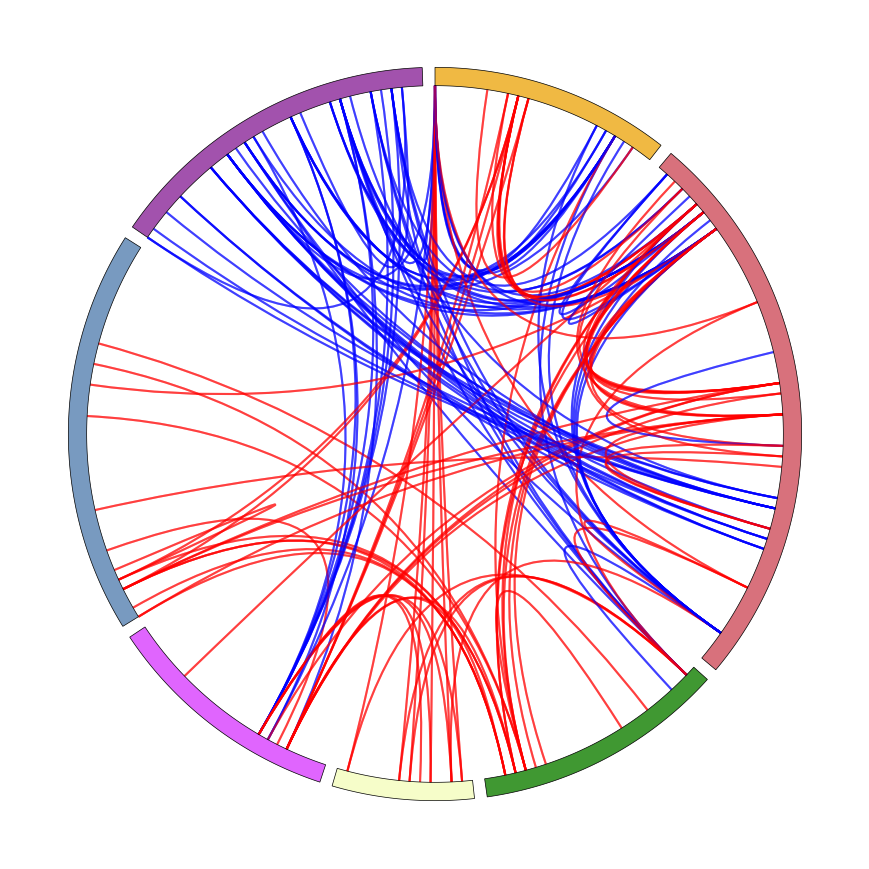

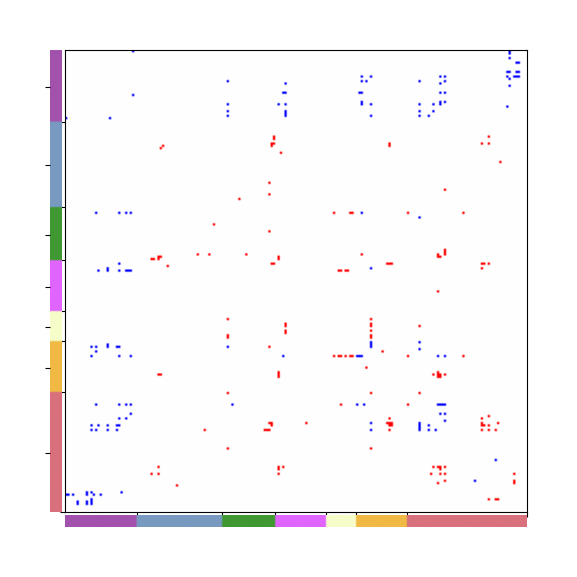

In [9]:
sectors, left_mat_df_dist = prepare_SchaeferSectors(LSchaefer, left_mat_dist, "L")
generate_circos_plot(left_mat_df_dist, sectors, rsn_colors)
plot_heatmap(left_mat_df_dist, rsn_colors)

### Left hemisphere FC edges by network in Schaefer 400

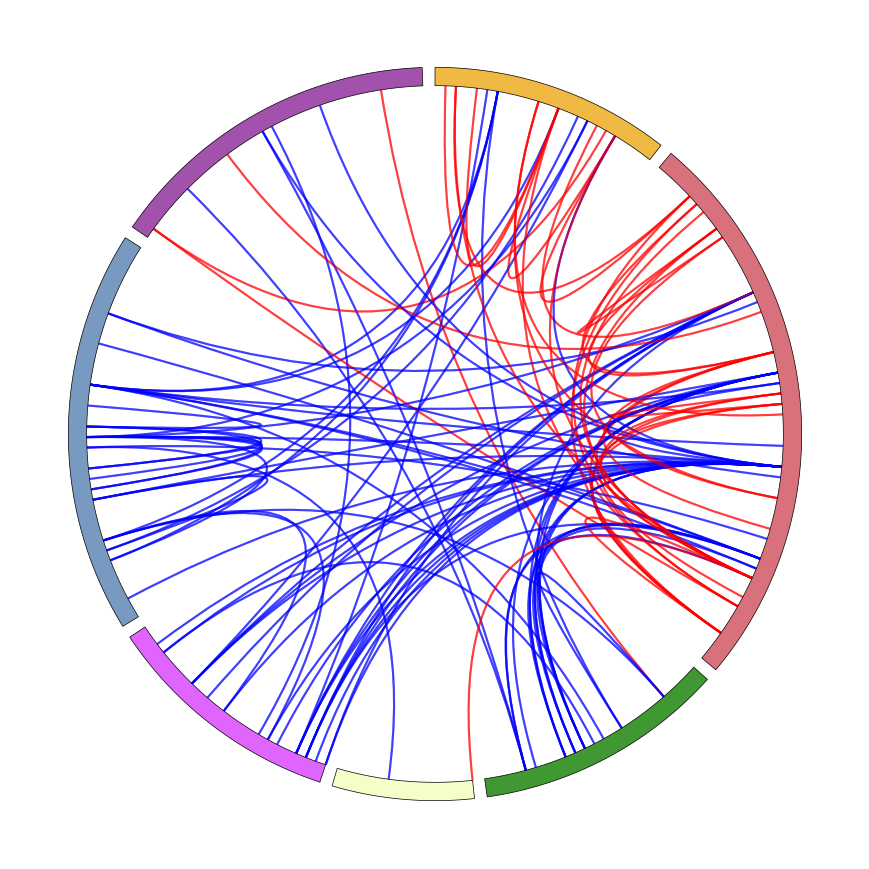

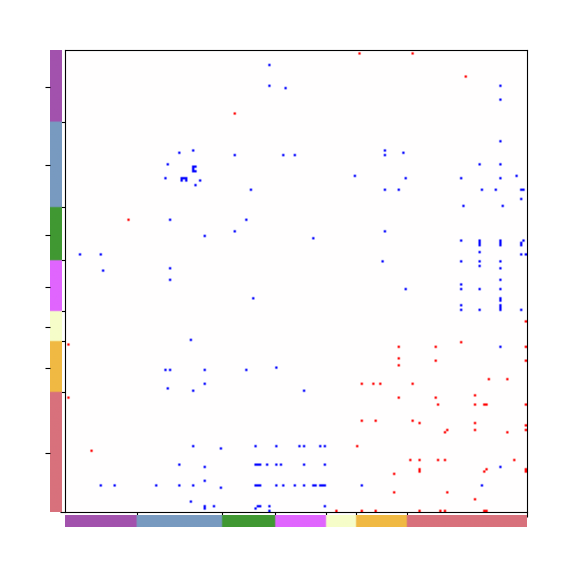

In [10]:
sectors, left_mat_df_FC = prepare_SchaeferSectors(LSchaefer, left_mat_FC, "L")
generate_circos_plot(left_mat_df_FC, sectors, rsn_colors)
plot_heatmap(left_mat_df_FC, rsn_colors)

### Right hemisphere distances by network in Schaefer 400

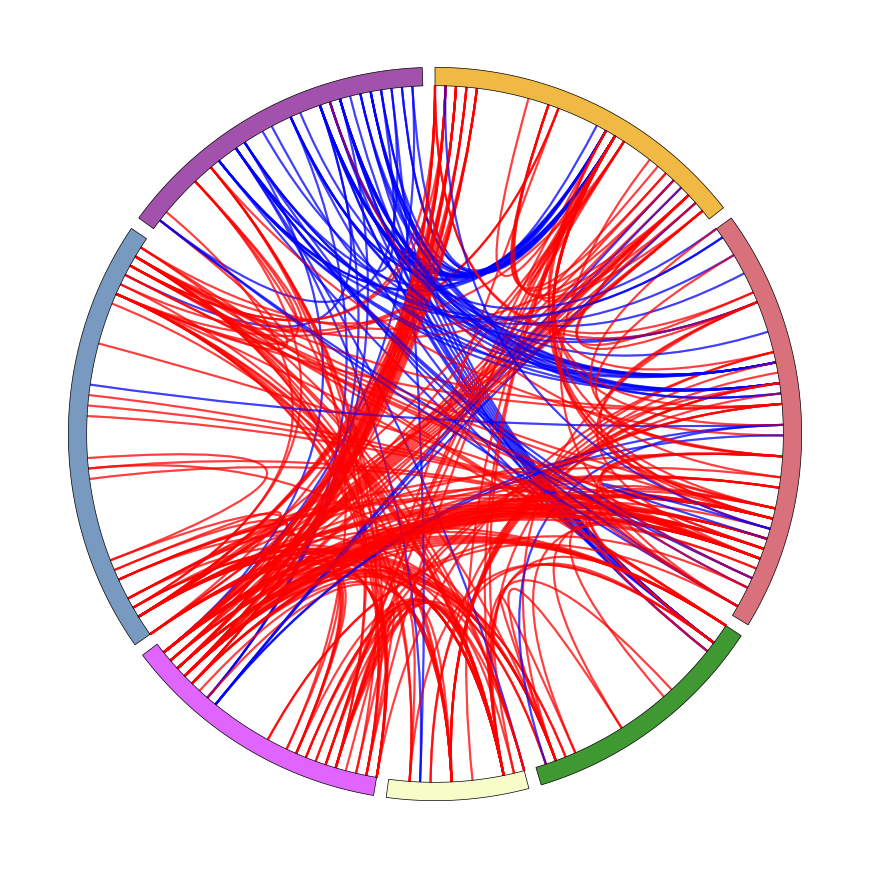

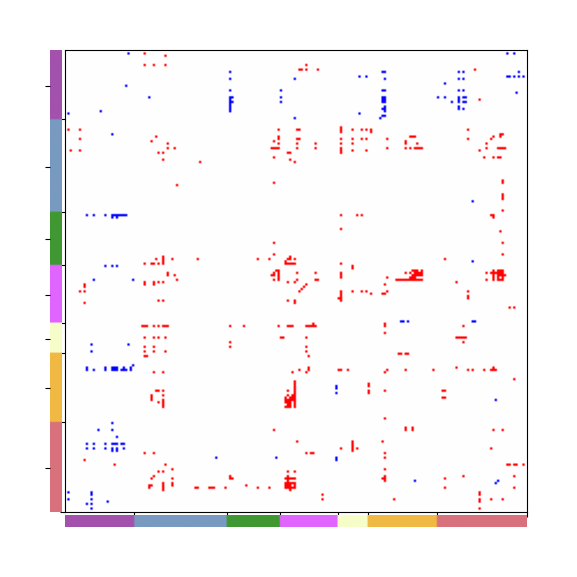

In [11]:
sectors, right_mat_df_dist = prepare_SchaeferSectors(RSchaefer, right_mat_dist, "R")
generate_circos_plot(right_mat_df_dist, sectors, rsn_colors)
plot_heatmap(right_mat_df_dist, rsn_colors)

### Right hemisphere FC edges by network in Schaefer 400

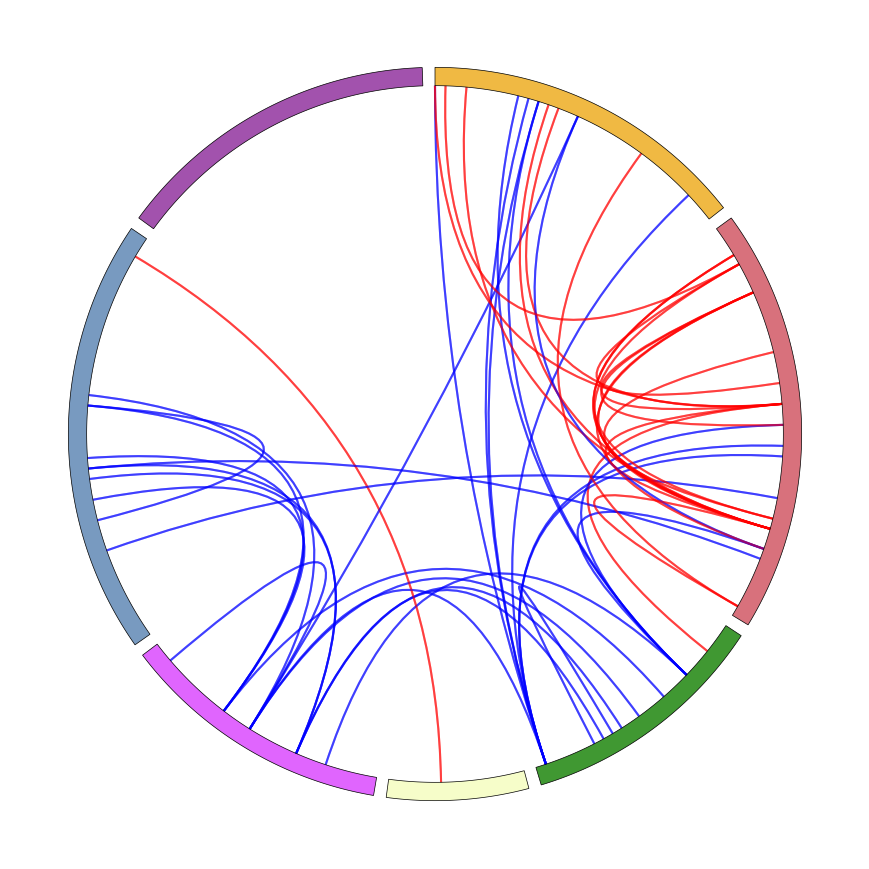

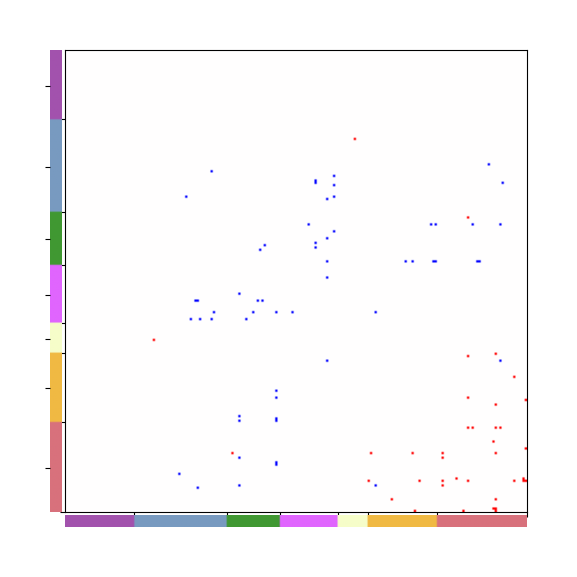

In [12]:
sectors, right_mat_df_FC = prepare_SchaeferSectors(RSchaefer, right_mat_FC, "R")
generate_circos_plot(right_mat_df_FC, sectors, rsn_colors)
plot_heatmap(right_mat_df_FC, rsn_colors)

## Visualizing features on the brain

In [13]:
#### function to get list of distances touching a given Yeo network in Schaefer atlas
def network_specific_lists(pos_dist, neg_dist):
    redes = ["Vis", "SomMot", "DorsAttn", "SalVentAttn", "Limbic", "Cont", "Default"]
    nwork_dists = {}
    for red in redes:
        nwork_dists[f"Network: {red}"] = [i for i in pos_dist if red in i] + [
            i for i in neg_dist if red in i
        ]
    nwork_dists_cleanedkeys = {
        key.split(" ")[1]: value for key, value in nwork_dists.items()
    }

    return nwork_dists_cleanedkeys


#### function gets pairwise ablations
def internetwork_lists(pos_dist, neg_dist):
    redes = ["Vis", "SomMot", "DorsAttn", "SalVentAttn", "Limbic", "Cont", "Default"]
    inclusion = {}
    for red in redes:
        red_pos = [i for i in pos_dist if red in i]
        red_neg = [i for i in neg_dist if red in i]
        nw_dist = red_pos + red_neg

        for subred in redes:
            sr_dist = [i for i in nw_dist if subred in i]
            if subred == red:
                within_nw = []
                for i in nw_dist:
                    edge = i.split("--")
                    node1 = edge[0]
                    node2 = edge[1]
                    if red in node1 and red in node2:
                        within_nw.append(i)
                sr_dist = within_nw

            inclusion[f"{red}--{subred}"] = sr_dist

    return inclusion


def split_subsets_posvneg(FeatureDict, PosFeatures, NegFeatures):
    p_dict = {}
    n_dict = {}
    for i in FeatureDict:
        p_dict[i] = [k for k in FeatureDict[i] if k in PosFeatures]
        n_dict[i] = [j for j in FeatureDict[i] if j in NegFeatures]
    return p_dict, n_dict

In [14]:
#### subsets of distances
subset_models = network_specific_lists(
    positiveDistances["ReadEng_Unadj"], negativeDistances["ReadEng_Unadj"]
)
internnetworkDists = internetwork_lists(
    positiveDistances["ReadEng_Unadj"], negativeDistances["ReadEng_Unadj"]
)
subset_models.update(internnetworkDists)
empty_keys = [i for i in subset_models.keys() if len(subset_models[i]) == 0]
for i in empty_keys:
    del subset_models[i]

DistDict = {
    "Full Model": positiveDistances["ReadEng_Unadj"]
    + negativeDistances["ReadEng_Unadj"]
}
DistDict.update(subset_models)

In [15]:
PosDictDist, NegDictDist = split_subsets_posvneg(
    DistDict, positiveDistances["ReadEng_Unadj"], negativeDistances["ReadEng_Unadj"]
)

In [16]:
### modality dictionaries set up a little different
modalityDictPos = {
    "Cortical Distance": positiveDistances["ReadEng_Unadj"],
    "Functional Connectivity": positiveFC["ReadEng_Unadj"],
}
modalityDictNeg = {
    "Cortical Distance": negativeDistances["ReadEng_Unadj"],
    "Functional Connectivity": negativeFC["ReadEng_Unadj"],
}

In [17]:
#### load precalculated paths on the S1200 midthickness surface
### used for visualization only

f = open(f"{data_dir}/Left.Schaefer400Paths.json")
left_paths = json.load(f)
f = open(f"{data_dir}/Right.Schaefer400Paths.json")
right_paths = json.load(f)

### match the path parcel keys to the entries of our distances here
left_paths_matchedKeys = {
    f"L.{key.replace('7Networks_LH_', '')}": value for key, value in left_paths.items()
}
right_paths_matchedKeys = {
    f"R.{key.replace('7Networks_RH_', '')}": value for key, value in right_paths.items()
}

### Set up the giftis arrays for the giftis for each dictonary

In [18]:
def setup_model_giftis(dataDict, lpaths, rpaths):
    lh_arrays = {}
    rh_arrays = {}
    for key in dataDict:
        ### extract the left and right hemis for each dict
        lh = [i for i in dataDict[key] if "L." in i]
        rh = [i for i in dataDict[key] if "R." in i]
        ### empty arrays to plot on
        surfed_metricL = np.zeros(32492)
        surfed_metricR = np.zeros(32492)

        for edge in lh:
            surfed_metricL[lpaths[edge]] = 1
        for edge in rh:
            surfed_metricR[rpaths[edge]] = 1
        lh_arrays[key] = surfed_metricL
        rh_arrays[key] = surfed_metricR
    return lh_arrays, rh_arrays

In [19]:
### set up
ModalityCompFeaturesLPos, ModalityCompFeaturesRPos = setup_model_giftis(
    modalityDictPos, left_paths_matchedKeys, right_paths_matchedKeys
)
ModalityCompFeaturesLNeg, ModalityCompFeaturesRNeg = setup_model_giftis(
    modalityDictNeg, left_paths_matchedKeys, right_paths_matchedKeys
)
### set up ablated model gifti dicts
LeftAblatedPos, RightAblatedPos = setup_model_giftis(
    PosDictDist, left_paths_matchedKeys, right_paths_matchedKeys
)
LeftAblatedNeg, RightAblatedNeg = setup_model_giftis(
    NegDictDist, left_paths_matchedKeys, right_paths_matchedKeys
)

In [20]:
def save_labeled_gifti(data_dict, out):
    """
    Save a dictionary of labeled arrays to a single GIFTI file.

    Parameters:
    data_dict (dict): Dictionary where keys are labels (names of arrays)
                      and values are 1D numpy arrays.
    out (str): Output file path (without extension).
    """
    gi = nib.gifti.GiftiImage()

    for label, array in data_dict.items():
        # Create a GiftiDataArray for each labeled array
        da = nib.gifti.GiftiDataArray(
            np.float32(array),
            intent=0,  # FUNC data intent
            meta=nib.gifti.GiftiMetaData({"Name": label}),
        )
        gi.add_gifti_data_array(da)

    # Save to GIFTI format
    nib.save(gi, f"{out}.func.gii")

In [21]:
!mkdir -p FeatureGiftis

In [22]:
### modality comparison giftis
save_labeled_gifti(
    ModalityCompFeaturesLPos, "FeatureGiftis/ModalityCompFeatures.L.Positive"
)
save_labeled_gifti(
    ModalityCompFeaturesRPos, "FeatureGiftis/ModalityCompFeatures.R.Positive"
)

save_labeled_gifti(
    ModalityCompFeaturesLNeg, "FeatureGiftis/ModalityCompFeatures.L.Negative"
)
save_labeled_gifti(
    ModalityCompFeaturesRNeg, "FeatureGiftis/ModalityCompFeatures.R.Negative"
)

In [23]:
### distance only giftis

save_labeled_gifti(LeftAblatedPos, "FeatureGiftis/ModelAblationFeatures.L.Positive")
save_labeled_gifti(RightAblatedPos, "FeatureGiftis/ModelAblationFeatures.R.Positive")

save_labeled_gifti(LeftAblatedNeg, "FeatureGiftis/ModelAblationCompFeatures.L.Negative")
save_labeled_gifti(
    RightAblatedNeg, "FeatureGiftis/ModelAblationCompFeatures.R.Negative"
)

### Finished 